# Previsão de renda

### 4 elementos importantes
- Esse notebook
- Streamlit com as análises
- Seu Github com o projeto
- Vídeo no readme do github mostrando o streamlit

## Etapa 1 CRISP - DM: Entendimento do negócio

Como primeira etapa do CRISP-DM, vamos entender do que se trata o negócio, e quais os objetivos.  
  
Essa é uma base de proponentes de cartão de crédito, nosso objetivo é construir um modelo preditivo para explicar/prever a variável renda através de variáveis que podem ser observadas na data da avaliação do crédito (tipicamente quando o cliente solicita o cartão).

Atividades do CRISP-DM:

- Objetivos do negócio
Note que o objetivo aqui é que o modelo sirva o mutuário (o cliente) para que avalie suas próprias decisões.
- Objetivos da modelagem
O objetivo está bem definido: desenvolver o melhor modelo preditivo de modo a explicar/prever a renda do cliente.


## Etapa 2 Crisp-DM: Entendimento dos dados

A segunda etapa é o entendimento dos dados. Foram fornecidas 13 variáveis mais a variável resposta (em negrito na tabela). O significado de cada uma dessas variáveis se encontra na tabela.


### Dicionário de dados

Os dados estão dispostos em uma tabela com uma linha para cada cliente, e uma coluna para cada variável armazenando as características desses clientes. Colocamos uma cópia o dicionário de dados (explicação dessas variáveis) abaixo neste notebook:


| Variável                | Descrição                                           | Tipo         |
| ----------------------- |:---------------------------------------------------:| ------------:|
| data_ref                |  Data de referência                                 |     texto    |
| id_cliente              |  Identificador do banco de dados                    |    inteiro   |
| sexo                    |  M = 'Masculino'; F = 'Feminino'                    |     M/F      |
| posse_de_veiculo        |  Y = 'possui'; N = 'não possui'                     |     Y/N      |
| posse_de_imovel         |  Y = 'possui'; N = 'não possui'                     |     Y/N      |
| qtd_filhos              |  Quantidade de filhos                               |    inteiro   |
| tipo_renda              |  Tipo de renda (ex: assaliariado, autônomo etc)     |     texto    |
| educacao                |  Nível de educação (ex: secundário, superior etc)   |     texto    |
| estado_civil            |  Estado civil (ex: solteiro, casado etc)            |     texto    |
| tipo_residencia         |  tipo de residência (ex: casa/apartamento, com os pais etc)  |     texto    |
| idade                   |  idade em anos                                      |    inteiro   |
| tempo_emprego           |  tempo de emprego em anos                           |    inteiro   |
| qt_pessoas_residencia   |  quantidade de pessoas na residência                |    inteiro   |
| **renda**               |  Renda do cliente                                   |  número real |


#### Carregando os pacotes
É considerado uma boa prática carregar os pacotes que serão utilizados como a primeira coisa do programa.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl # recurso adicional de plotagem
import ydata_profiling
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import graphviz
import joblib
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn import tree

#renderiza a plotagem automaticamente
%matplotlib inline

#### Carregando os dados
O comando pd.read_csv é um comando da biblioteca pandas (pd.) e carrega os dados do arquivo csv indicado para um objeto *dataframe* do pandas.

In [2]:
renda = pd.read_csv('./input/previsao_de_renda.csv')

In [3]:
renda.head(1)

,Unnamed: 0,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,0,2015-01-01,15056,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.60274,1.0,8060.34


#### Entendimento dos dados - Univariada
Nesta etapa tipicamente avaliamos a distribuição de todas as variáveis. Realizaremos antes, pequenos ajustes nos dados para melhor visualização via **Panda Profiling**.

In [4]:
renda.drop('Unnamed: 0', axis = 1, inplace = True)

In [5]:
renda['data_ref'] = pd.to_datetime(renda.data_ref)

In [6]:
renda['tipo_renda'].replace('Servidor público','Servidor_público', inplace = True)
renda['educacao'].replace(['Superior completo','Superior incompleto','Pós graduação'],['Superior_completo','Superior_incompleto','Pós_graduação'], inplace = True)
renda['tipo_residencia'].replace('Com os pais','Com_os_pais', inplace = True)

In [7]:
prof = ProfileReport(renda, explorative=True, minimal=True)
prof

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
prof.to_file('./output/renda_analisys.html')

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#### <span style="color:blue">Análise:</span>
* Há <span style="color:red">**2573 dados missing**</span>, sendo que todos na variável **'tempo_emprego'**;
* A base de dados é formada por clientes que:
    - foram cadastrados entre 01/01/2015 a 01/03/2016;
    - predominantemente é do **sexo feminino (67.50%)**;
    - predominantemente **não possuem veículo (60.90%)**;
    - na maioria **possuem imóvel (67.60%)**;
    - na maioria **não possuem filhos (69.20%)** e com 95% destes com até 2 filhos;
    - apresentam tipo de renda predominante de **assalariados (50.90%)**, e seguido por aproximadamente 25% do tipo empresário;
    - na maioria possuem escolaridade **'secundário' (59.30%)**, seguido da escolaridade 'superior' (35.60%), totalizando quase 95% para estas duas categorias;
    - os **casados** representam 70.20%;
    - 90.20% possuem **casa**;
    - metade apresentam idade até **43 anos**;
    - aproximadamente 50% apresentam até **6 anos de emprego**;
    - predominantemente tem família constituída por poucas pessoas **(95% até 4 pessoas)**; e
    - 75% tem renda aproximada de até 6392.16, sendo que **metade com aproximadamente 50% deste valor**.

### Entendimento dos dados - Bivariadas

Entender a alteração da variável resposta renda em função das variáveis explicativas (demais). Para isto, vamos calcular a renda para diferentes grupos definidos pelas variáveis explicativas.


In [9]:
# Identificando as variáveis explicativas
renda.columns

Index(['data_ref', 'id_cliente', 'sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda'],
      dtype='object')

<Axes: xlabel='posse_de_veiculo', ylabel='renda'>

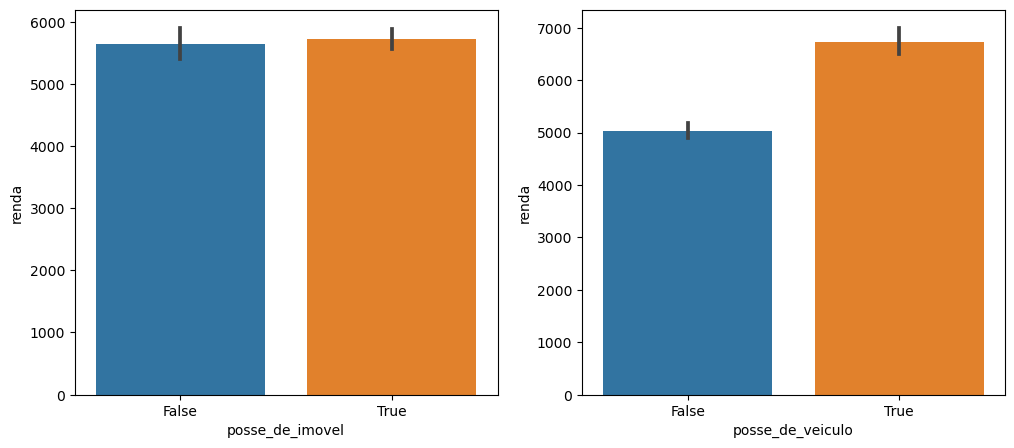

In [10]:
# Gerando os gráficos para as variáveis 'posse de imóvel' e 'posse de veículo'
fig, ax = plt.subplots(1,2,figsize=(12,5))
sns.barplot(x='posse_de_imovel',y='renda',data=renda, ax=ax[0])
sns.barplot(x='posse_de_veiculo',y='renda',data=renda, ax=ax[1])

<Axes: xlabel='qt_pessoas_residencia', ylabel='renda'>

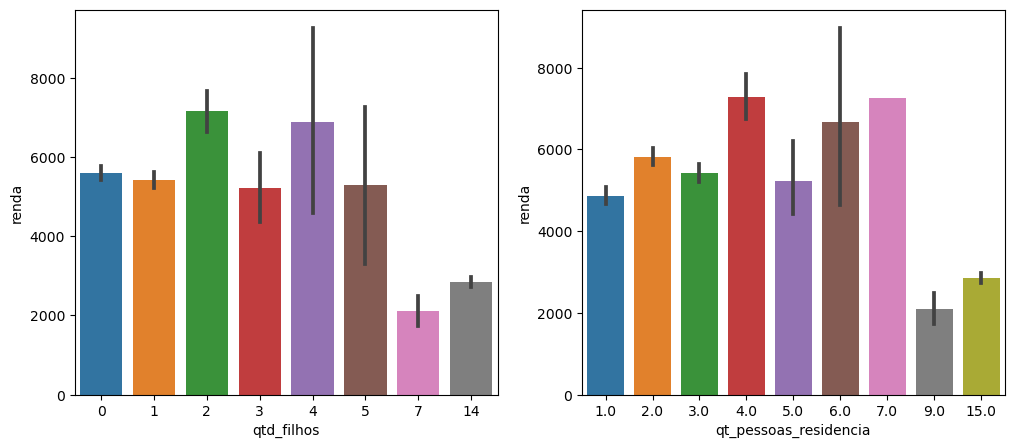

In [11]:
# Gerando os gráficos para as variáveis 'qtd_filhos' e 'qt_pessoas_residencia'
fig, ax = plt.subplots(1,2,figsize=(12,5))
sns.barplot(x='qtd_filhos',y='renda',data=renda, ax=ax[0])
sns.barplot(x='qt_pessoas_residencia',y='renda',data=renda, ax=ax[1])

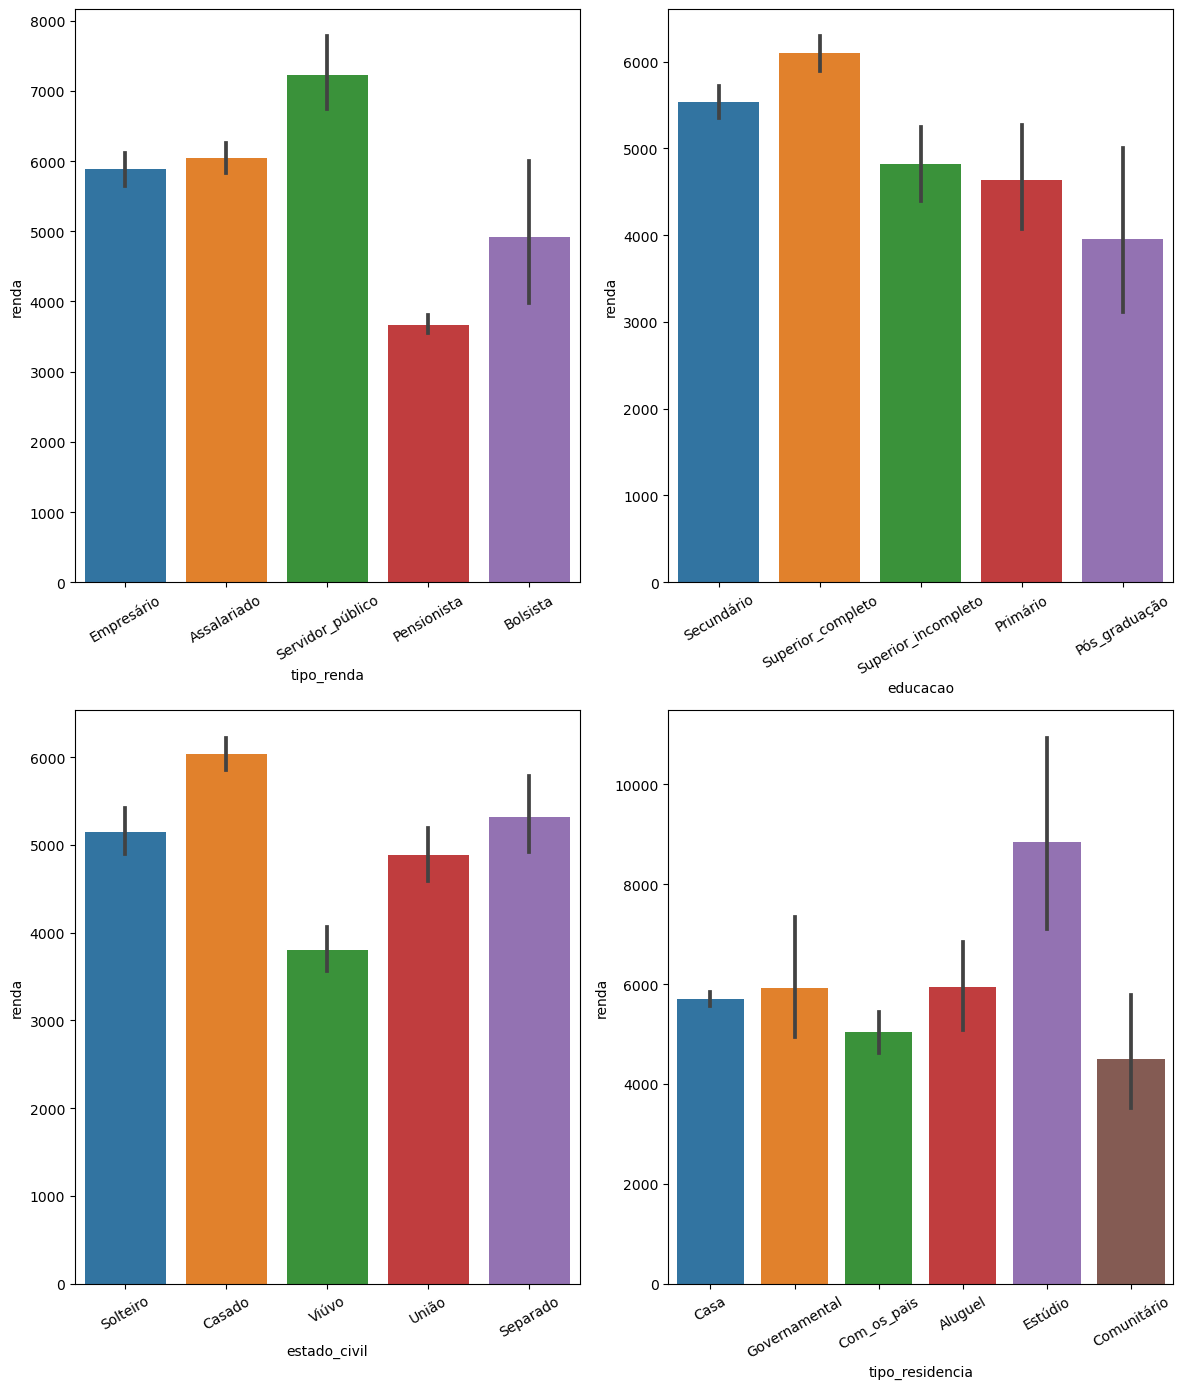

In [12]:
# Gerando os gráficos para as variáveis 'tipo_renda', 'educacao', 'estado_civil' e 'tipo_residencia'
fig1, axs = plt.subplots(2,2,figsize=(12,14))
sns.barplot(x='tipo_renda',y='renda',data=renda, ax=axs[0,0])
sns.barplot(x='educacao',y='renda',data=renda, ax=axs[0,1])
sns.barplot(x='estado_civil',y='renda',data=renda, ax=axs[1,0])
sns.barplot(x='tipo_residencia',y='renda',data=renda, ax=axs[1,1])
for ax in axs.flat:
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.tight_layout()

In [13]:

# Gerando listas com as categorias das variáveis 'educacao' e 'tipo_renda'
ed_categorias = renda['educacao'].unique().tolist()
tr_categorias = renda['tipo_renda'].unique().tolist()

In [14]:
# Visualizando a distribuição das categorias da variável 'educaçao' por cada categoria da variável 'tipo_renda'
df_renda = pd.DataFrame(index = tr_categorias)
for ed_categoria in ed_categorias:
    df_renda[""+ed_categoria+""] = renda[renda['educacao'] == ed_categoria]['tipo_renda'].value_counts()
    lista = []
    for tr_categoria in tr_categorias:
        renda_media = renda[(renda['educacao'] == ed_categoria) & (renda['tipo_renda'] == tr_categoria)]['renda'].mean()
        lista.append(renda_media)
    df_renda["Média_"+ed_categoria+""] = lista
df_renda = df_renda.fillna(0)
df_renda

,Secundário,Média_Secundário,Superior_completo,Média_Superior_completo,Superior_incompleto,Média_Superior_incompleto,Primário,Média_Primário,Pós_graduação,Média_Pós_graduação
Empresário,1777.0,5766.715267,1513,6259.693424,187.0,4397.123209,17.0,3180.466471,14.0,3827.192143
Assalariado,4672.0,6070.662230,2533,6147.728370,335.0,5055.060000,81.0,5563.942963,12.0,4110.858333
Servidor_público,595.0,7228.127529,632,7309.532563,36.0,6150.063333,5.0,4033.844000,0.0,0.000000
Pensionista,1851.0,3433.103539,648,4368.528735,21.0,2471.610476,62.0,3864.517419,0.0,0.000000
Bolsista,0.0,0.000000,9,4924.911111,0.0,0.000000,0.0,0.000000,0.0,0.000000


In [15]:
# Verificando a frequência das categorias da variável 'tipo_renda' quando o estado civil é 'Viúvo'
renda[renda['estado_civil'] == 'Viúvo']['tipo_renda'].value_counts()

tipo_renda
Pensionista         387
Assalariado         210
Empresário           62
Servidor_público     52
Name: count, dtype: int64

In [16]:
# Verificando a frequência das categorias da variável 'tipo_renda' quando o tipo de residência é 'Estúdio'
renda[renda['tipo_residencia'] == 'Estúdio']['tipo_renda'].value_counts()

tipo_renda
Empresário          28
Assalariado         28
Servidor_público    19
Pensionista          8
Name: count, dtype: int64

In [17]:
# Calculando a renda média de cliente 'Empresário' e que residem em 'Estúdio'
renda[(renda['tipo_residencia'] == 'Estúdio') & (renda['tipo_renda'] == 'Empresário')]['renda'].mean()

11449.927857142857

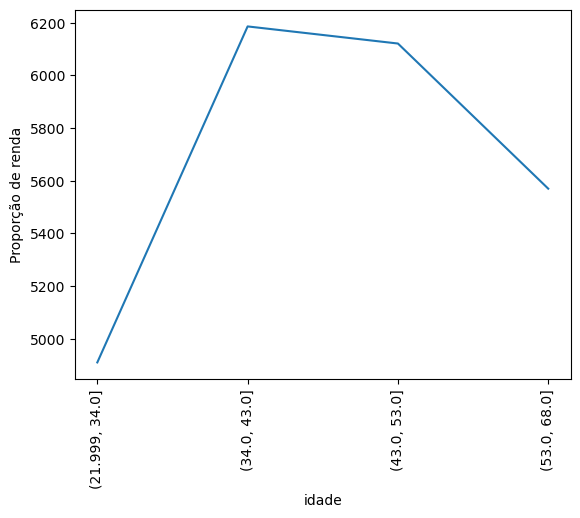

In [54]:
# Gerando o gráfico da variação da renda em função da idade
var = 'idade'
cat_srs, bins = pd.qcut(renda[var], 4, retbins=True)
g = renda.groupby(cat_srs)
biv = g['renda'].mean()

ax = biv.plot.line()
ax.set_ylabel("Proporção de renda")
ticks = plt.xticks(range(len(biv.index.values)), biv.index.values, rotation = 90)

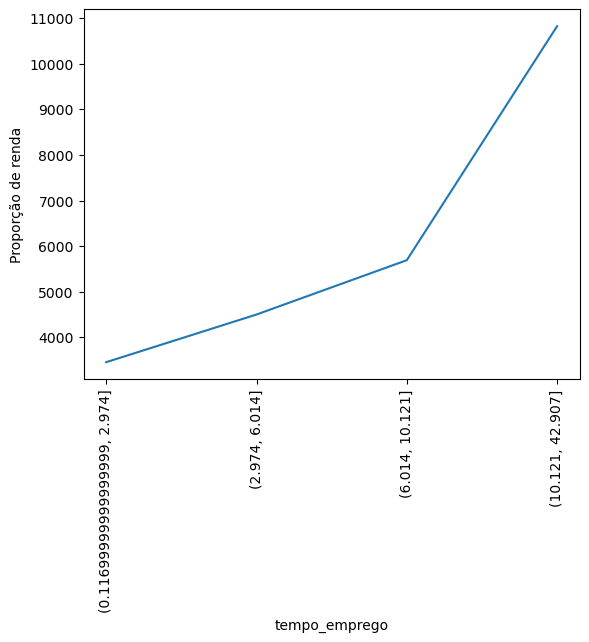

In [19]:
# Gerando o gráfico da variação da renda em função do tempo de emprego
var = 'tempo_emprego'
cat_srs, bins = pd.qcut(renda[var], 4, retbins=True)
g = renda.groupby(cat_srs)
biv = g['renda'].mean()

ax = biv.plot.line()
ax.set_ylabel("Proporção de renda")
ticks = plt.xticks(range(len(biv.index.values)), biv.index.values, rotation = 90)

#### <span style="color:blue">Análise:</span>
* A renda vista em relação as variáveis explicativas:
    - possuir imóvel não parece mudar a renda do cliente;
    - possuir veículo influencia positivamente na renda do cliente;
    - ter mais de 5 filhos influencia negativamente na renda do cliente, apresentando queda significativa na renda média;
    - situação semelhante ocorre em ter mais de 07 pessoas na residência;
    - o tipo de renda 'servidor público' apresenta a melhor renda média, e 'pensionista' a pior;
    - estranhamente os clientes com 'pós-graduação' e 'superior_incompleto' apresentam renda média inferior aos clientes com 'secundário', situação evidenciada também quando se compara a renda média por tipo de renda (ver resultado do DataFrame 'df_renda');
    - os casados apresentam as melhores rendas médias e os viúvos as piores, este último explicado pela participação de mais de 50% de pensionistas;
    - os residentes em 'Estúdio' devergem dos demais por apresentar uma renda média para aqueles que apresentam tipo de renda 'Empresário'(aproximadamente 1/3) por volta dos 11449.92.
    - a renda média é maior na faixa de maturidade do cliente (entre 34 a 53 anos); e
    - a renda média é crescente em função do tempo de emprego, tendo uma acentuada no crescimento após os 10 anos.

## Etapa 3 Crisp-DM: Preparação dos dados
Nessa etapa realizamos tipicamente as seguintes operações com os dados:

 - **seleção**: Já temos os dados selecionados adequadamente?
 - **limpeza**: Precisaremos identificar e tratar dados faltantes
 - **construção**: construção de novas variáveis
 - **integração**: Temos apenas uma fonte de dados, não é necessário integração
 - **formatação**: Os dados já se encontram em formatos úteis?



In [20]:
# Verificando o tamanho da base
renda.shape

(15000, 14)

In [21]:
# Buscando linhas duplicadas pela variável 'id_cliente'
renda['id_cliente'].nunique()

9845

In [22]:
# Visualizando dados duplicados
id_counts = renda['id_cliente'].value_counts()
id_counts.value_counts()

count
1    6002
2    2808
3     800
4     199
5      30
6       6
Name: count, dtype: int64

In [23]:
# Visualizando os casos com 6 repetições
id_duplicados = id_counts == 6
lista_ids = list(id_counts.index[id_duplicados])
lista_ids

[9948, 9351, 8635, 6356, 5573, 6062]

In [24]:
renda[renda['id_cliente'] == 9948].head(6)

,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
203,2015-01-01,9948,F,False,False,0,Empresário,Secundário,Casado,Casa,39,3.175342,2.0,728.96
1493,2015-02-01,9948,F,False,False,0,Empresário,Secundário,Casado,Casa,39,3.175342,2.0,728.96
4412,2015-05-01,9948,F,False,False,0,Empresário,Secundário,Casado,Casa,39,3.175342,2.0,728.96
5406,2015-06-01,9948,F,False,False,0,Empresário,Secundário,Casado,Casa,39,3.175342,2.0,728.96
8116,2015-09-01,9948,F,False,False,0,Empresário,Superior_completo,Casado,Casa,39,3.175342,2.0,728.96
10215,2015-11-01,9948,F,False,False,0,Empresário,Secundário,Casado,Casa,39,3.175342,2.0,728.96


In [25]:
# Removendo a linhas duplicadas, deixando a última atualização
renda_nao_duplicada = renda.drop_duplicates(subset=['id_cliente'], keep = 'last')

In [26]:
# Visualizando tamanho da base
renda_nao_duplicada.shape

(9845, 14)

In [27]:
# Identificando a quantidade de valores 'missing'
renda_nao_duplicada['tempo_emprego'].isna().sum()

1684

In [28]:
# Verificando o 'tipo_renda' dos valores missing para a variável 'tempo_emprego'
renda_nao_duplicada[renda_nao_duplicada['tempo_emprego'].isna() == True]['tipo_renda'].value_counts()

tipo_renda
Pensionista    1684
Name: count, dtype: int64

In [29]:
# Preenchendo com '0' os valores missing pois os mesmos são pensionistas
renda_df = renda_nao_duplicada.fillna(0)
renda_df['tempo_emprego'].info()

<class 'pandas.core.series.Series'>
Index: 9845 entries, 0 to 14999
Series name: tempo_emprego
Non-Null Count  Dtype  
--------------  -----  
9845 non-null   float64
dtypes: float64(1)
memory usage: 153.8 KB


In [30]:
# Excluindo as variáveis que não serão utilizadas
renda_df.drop(['data_ref', 'id_cliente'], axis=1, inplace = True)
# Tratando os valores do tipo 'bool'
renda_df.posse_de_veiculo = [int(x) for x in renda_df.posse_de_veiculo]
renda_df.posse_de_imovel = [int(x) for x in renda_df.posse_de_imovel]
renda_df.head()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,F,0,1,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,M,1,1,0,Assalariado,Superior_completo,Casado,Casa,28,7.183562,2.0,1852.15
2,F,1,1,0,Empresário,Superior_completo,Casado,Casa,35,0.838356,2.0,2253.89
7,F,0,1,0,Empresário,Secundário,Casado,Casa,36,3.104110,2.0,2515.98
9,M,1,1,0,Assalariado,Superior_completo,Casado,Casa,60,10.558904,2.0,12939.14


In [31]:
renda_dummies = pd.get_dummies(renda_df, dtype = int)
renda_dummies.head()

,posse_de_veiculo,posse_de_imovel,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,sexo_F,sexo_M,tipo_renda_Assalariado,...,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Aluguel,tipo_residencia_Casa,tipo_residencia_Com_os_pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
0,0,1,0,26,6.602740,1.0,8060.34,1,0,0,...,0,1,0,0,0,1,0,0,0,0
1,1,1,0,28,7.183562,2.0,1852.15,0,1,1,...,0,0,0,0,0,1,0,0,0,0
2,1,1,0,35,0.838356,2.0,2253.89,1,0,0,...,0,0,0,0,0,1,0,0,0,0
7,0,1,0,36,3.104110,2.0,2515.98,1,0,0,...,0,0,0,0,0,1,0,0,0,0
9,1,1,0,60,10.558904,2.0,12939.14,0,1,1,...,0,0,0,0,0,1,0,0,0,0


## Etapa 4 Crisp-DM: Modelagem
Nessa etapa que realizaremos a construção do modelo. Os passos típicos são:
- Selecionar a técnica de modelagem
- Desenho do teste
- Avaliação do modelo


### Rodando o modelo


In [32]:
# Separando as variáveis X e y
X = renda_dummies.drop('renda', axis = 1)
y = renda_dummies["renda"]

In [33]:
# Dividindo os dados em treinamento e teste
X_train_arvore, X_test_arvore, y_train_arvore, y_test_arvore = train_test_split(X, y, test_size=0.25, random_state=42)

In [34]:
# Visualizando a base de treino 'X_train'
X_train_arvore.head(1)

,posse_de_veiculo,posse_de_imovel,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,sexo_F,sexo_M,tipo_renda_Assalariado,tipo_renda_Bolsista,...,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Aluguel,tipo_residencia_Casa,tipo_residencia_Com_os_pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
7921,0,1,0,39,0.380822,2.0,1,0,1,0,...,0,0,1,0,0,0,1,0,0,0


In [35]:
# Visualizando a base de treino 'y_train'
y_train_arvore.head(1)

7921    2183.92
Name: renda, dtype: float64

n_minimo,2,3,4,5,6,7,8,9
profundidade,,,,,,,,
2,4.943798e+07,4.943798e+07,4.943798e+07,4.943798e+07,4.943798e+07,4.943798e+07,4.943798e+07,4.943798e+07
3,3.917959e+07,3.917959e+07,4.023002e+07,4.023002e+07,4.023002e+07,4.023002e+07,4.023002e+07,4.044314e+07
4,3.567673e+07,3.567673e+07,3.733162e+07,3.764947e+07,3.764947e+07,3.764947e+07,3.764947e+07,3.845557e+07
5,3.390004e+07,3.395641e+07,3.615453e+07,3.649086e+07,3.661625e+07,3.661754e+07,3.662385e+07,3.760123e+07
6,3.181787e+07,3.215316e+07,3.477248e+07,3.526312e+07,3.543414e+07,3.555627e+07,3.556258e+07,3.653448e+07
7,3.028207e+07,3.078138e+07,3.391496e+07,3.447914e+07,3.467550e+07,3.480350e+07,3.482532e+07,3.574832e+07
8,2.877343e+07,2.947562e+07,3.285766e+07,3.340617e+07,3.375515e+07,3.388233e+07,3.390477e+07,3.497560e+07


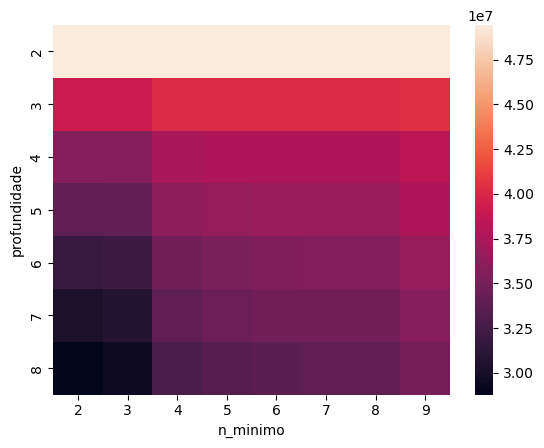

In [36]:
# Calculando o caminho indicado pelos CCP-alfas
mses = []
ind_i = []
ind_j = []

for i in range(2, 9):
    for j in range(2, 10):
        reg = DecisionTreeRegressor(max_depth=i, min_samples_leaf=j)
        reg.fit(X_train_arvore, y_train_arvore)
        mse1 = mean_squared_error(y_train_arvore, reg.predict(X_train_arvore))
        mses.append(mse1)
        ind_i.append(i)
        ind_j.append(j)
        
df_mse = pd.DataFrame({'mses':mses, 'profundidade':ind_i, 'n_minimo':ind_j})
sns.heatmap(df_mse.pivot(index='profundidade', columns='n_minimo', values='mses'))
df_mse.pivot(index='profundidade', columns='n_minimo', values='mses')

In [37]:
path = reg.cost_complexity_pruning_path(X_train_arvore, y_train_arvore)
path

{'ccp_alphas': array([0.00000000e+00, 5.94621797e+02, 1.13565870e+03, 1.39693007e+03,
        1.44478697e+03, 1.51458789e+03, 1.68047460e+03, 2.14939414e+03,
        2.51276452e+03, 2.74096812e+03, 3.21829108e+03, 3.27210156e+03,
        3.43708468e+03, 3.50019840e+03, 3.60740365e+03, 3.67693441e+03,
        3.89454375e+03, 4.17848064e+03, 4.20128618e+03, 4.34031075e+03,
        4.61441567e+03, 4.63223001e+03, 4.88671190e+03, 5.01999841e+03,
        5.05426716e+03, 5.13424737e+03, 5.21905676e+03, 5.21946079e+03,
        5.23659964e+03, 6.40096045e+03, 6.70724952e+03, 7.15084761e+03,
        7.19829167e+03, 7.26854434e+03, 7.84097311e+03, 7.86598550e+03,
        7.91107604e+03, 8.65744315e+03, 8.66907952e+03, 8.86849259e+03,
        9.16929746e+03, 1.12145726e+04, 1.15919497e+04, 1.19847832e+04,
        1.23819056e+04, 1.28747611e+04, 1.29409266e+04, 1.32913467e+04,
        1.43948887e+04, 1.46577185e+04, 1.47942414e+04, 1.73956270e+04,
        1.84336292e+04, 1.89785699e+04, 2.13729579

Text(0, 0.5, 'Impureza total das folhas')

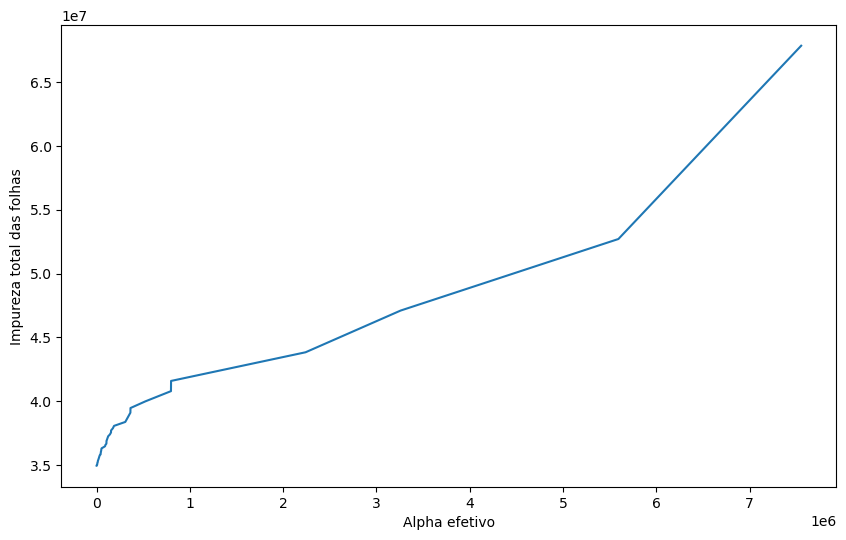

In [38]:
# Plotando o gráfixo ccp_alphas x impurities
ccp_alphas, impurities = path.ccp_alphas, path.impurities

plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, impurities)
plt.xlabel("Alpha efetivo")
plt.ylabel("Impureza total das folhas")

In [39]:
# treinando uma árvore com o respectivo alfa, e guardando essa árvore em uma lista.
clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train_arvore, y_train_arvore)
    clfs.append(clf)

Text(0, 0.5, 'Profundidade da árvore')

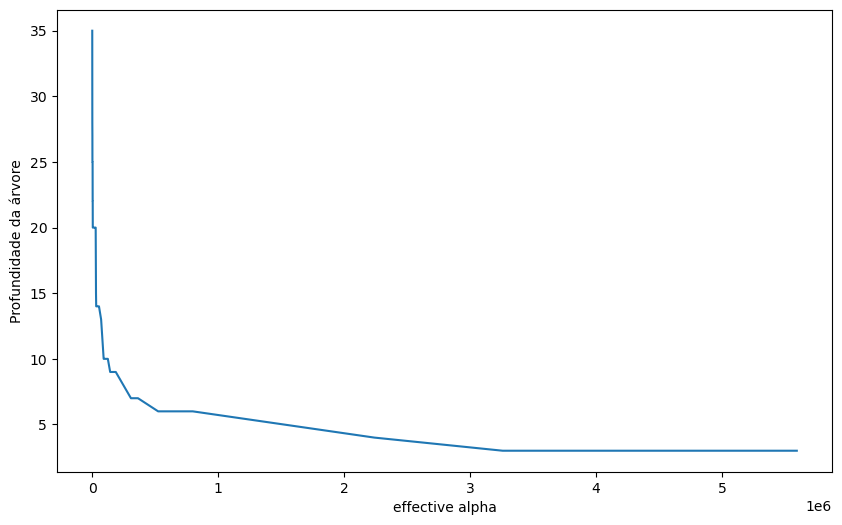

In [40]:
# Plotando o gráfixo ccp_alphas x tree_depths
tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Profundidade da árvore")

In [41]:
# Calculando o mse.
train_scores = [mean_squared_error(y_train_arvore, clf.predict(X_train_arvore)) for clf in clfs]
test_scores  = [mean_squared_error(y_test_arvore, clf.predict(X_test_arvore )) for clf in clfs]

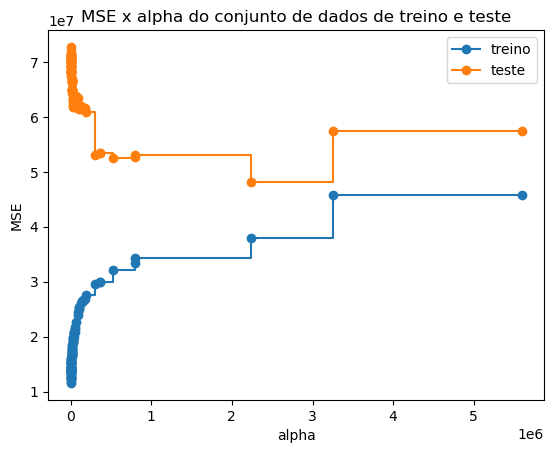

In [42]:
# Montando um gráfico do MSE pelo alpha, para escolha de um valor de alpha perto do ponto de mínimo do MSE
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("MSE")
ax.set_title("MSE x alpha do conjunto de dados de treino e teste")
ax.plot(ccp_alphas[:-1], train_scores[:-1], marker='o', label="treino",
        drawstyle="steps-post")
ax.plot(ccp_alphas[:-1], test_scores[:-1], marker='o', label="teste",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [43]:
# Escolhendo o valor de alpha com o menor MSE para a base de teste
best_alpha = ccp_alphas[test_scores.index(min(test_scores))]
print(f"Melhor valor de alpha: {best_alpha}")

Melhor valor de alpha: 2240317.0816851575


In [44]:
# Criando e ajustando a árvore de regressão com o melhor alpha
arvore_final = DecisionTreeRegressor(ccp_alpha=best_alpha)
arvore_final.fit(X_train_arvore, y_train_arvore)

DecisionTreeRegressor(ccp_alpha=2240317.0816851575)

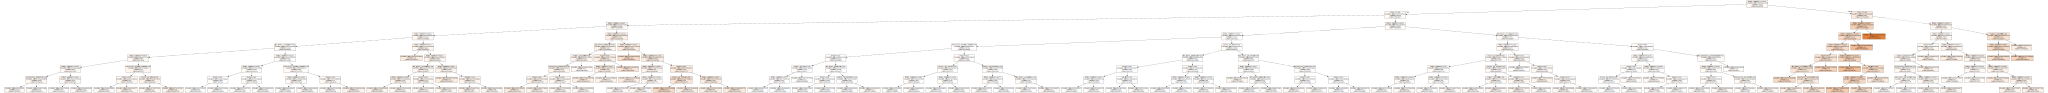

In [45]:
# Visualizando a árvore de regressão final
# DOT data
dot_data = tree.export_graphviz(reg, out_file=None, 
                                feature_names=X.columns,
                                filled=True)
# Draw graph
graph = graphviz.Source(dot_data, format = "png") 
graph

In [46]:
# Rodando um modelo stepwise para comparação
y_test, X_test = patsy.dmatrices('np.log(renda) ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia', data = renda_df, return_type="dataframe")

In [47]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.05, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded, dtype=np.dtype('float64'))
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.index[new_pval.argmin()]
            included.append(best_feature)
            changed=True
            if verbose:
                 print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        print("#############")
        print(included)
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [48]:
variaveis = stepwise_selection(X_test, y_test)

print('resulting features:')
print(variaveis)

Add  tempo_emprego                  with p-value 0.0
#############
['tempo_emprego']
Add  Intercept                      with p-value 0.0
#############
['tempo_emprego', 'Intercept']
Add  sexo[T.M]                      with p-value 0.0
#############
['tempo_emprego', 'Intercept', 'sexo[T.M]']
Add  tipo_renda[T.Pensionista]      with p-value 6.84551e-46
#############
['tempo_emprego', 'Intercept', 'sexo[T.M]', 'tipo_renda[T.Pensionista]']
Add  tipo_renda[T.Empresário]       with p-value 1.28653e-16
#############
['tempo_emprego', 'Intercept', 'sexo[T.M]', 'tipo_renda[T.Pensionista]', 'tipo_renda[T.Empresário]']
Add  educacao[T.Superior_completo]  with p-value 8.33683e-15
#############
['tempo_emprego', 'Intercept', 'sexo[T.M]', 'tipo_renda[T.Pensionista]', 'tipo_renda[T.Empresário]', 'educacao[T.Superior_completo]']
Add  posse_de_imovel                with p-value 6.57152e-12
#############
['tempo_emprego', 'Intercept', 'sexo[T.M]', 'tipo_renda[T.Pensionista]', 'tipo_renda[T.Empresário]

In [49]:
X_stepwise = X_test[['Intercept', 'sexo[T.M]', 'tempo_emprego', 'tipo_renda[T.Pensionista]', 'tipo_renda[T.Empresário]', 'educacao[T.Superior_completo]', 'posse_de_imovel', 'idade', 'tipo_renda[T.Servidor_público]', 'qt_pessoas_residencia']]
reg = sm.OLS(y_test, X_stepwise).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     577.4
Date:                Thu, 02 Nov 2023   Prob (F-statistic):               0.00
Time:                        21:24:11   Log-Likelihood:                -10652.
No. Observations:                9845   AIC:                         2.132e+04
Df Residuals:                    9835   BIC:                         2.140e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          7.0782      0.047    151.989      0.000       6.987       7.169
sexo[T.M]                          0.8123      0.016     50.931      0.000       0.781       0.844
tempo_emprego                      0.0607      0.001     47.994      0.000       0.058       0.063
tipo_renda[T.Pensionista]          0.2714      0.029      9.300      0.000       0.214       0.329
tipo_renda[T.Empresário]           0.1543      0.018      8.460      0.000       0.119       0.190
educacao[T.Superior_completo]      0.1179      0.015      7.818      0.000       0.088       0.147
posse_de_imovel                    0.0974      0.016      6.264      0.000       0.067       0.128
idade                              0.0053      0.001      5.970      0.000       0.004       0.007
tipo_renda[T.Servidor_público]     0.0829      0.027      3.063      0.002       0.030       0.136
qt_pessoas_residencia              0.0193      0.008      2.291      0.022       0.003       0.036
==============================================================================
Omnibus:                        0.647   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.723   Jarque-Bera (JB):                0.611
Skew:                           0.005   Prob(JB):                        0.737
Kurtosis:                       3.037   Cond. No.                         306.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Etapa 5 Crisp-DM: Avaliação dos resultados


In [50]:
# Calculando o R-quadrado da árvore de regressão
print(f"Profundidade: {arvore_final.tree_.max_depth}")
print(f"MSE na base de treino: {mean_squared_error(y_train_arvore, arvore_final.predict(X_train_arvore)):.2f}")
print(f"R_quadrado na base de treino: {arvore_final.score(X_train_arvore, y_train_arvore):.2f}")
print(f"MSE na base de testes: {mean_squared_error(y_test_arvore, arvore_final.predict(X_test_arvore)):.2f}")
print(f"R_quadrado na base de testes: {arvore_final.score(X_test_arvore, y_test_arvore):.2f}")

Profundidade: 4
MSE na base de treino: 38026360.83
R_quadrado na base de treino: 0.44
MSE na base de testes: 48230190.66
R_quadrado na base de testes: 0.41


#### <span style="color:blue">Análise:</span>
* A árvore de regressão apresentou o melhor resultado.


## Etapa 6 Crisp-DM: Implantação
Nessa etapa colocamos em uso o modelo desenvolvido, normalmente implementando o modelo desenvolvido em um motor que toma as decisões com algum nível de automação.

In [51]:
# Salvando arquivo com o modelo treinado
joblib.dump(arvore_final, 'arvore_regresao.pkl')

['arvore_regresao.pkl']

In [52]:
# Carregando o modelo quando necessário
modelo = joblib.load('arvore_regresao.pkl')

In [53]:
# Calculando o R-quadrado do modelo
print(f"Profundidade: {modelo.tree_.max_depth}")
print(f"MSE na base de treino: {mean_squared_error(y_train_arvore, modelo.predict(X_train_arvore)):.2f}")
print(f"R_quadrado na base de treino: {modelo.score(X_train_arvore, y_train_arvore):.2f}")
print(f"MSE na base de testes: {mean_squared_error(y_test_arvore, modelo.predict(X_test_arvore)):.2f}")
print(f"R_quadrado na base de testes: {modelo.score(X_test_arvore, y_test_arvore):.2f}")

Profundidade: 4
MSE na base de treino: 38026360.83
R_quadrado na base de treino: 0.44
MSE na base de testes: 48230190.66
R_quadrado na base de testes: 0.41
